# HW 1-3: Generalization
## CPSC 8430
## Adam Patyk

In [1]:
import numpy as np
import torch

from datetime import datetime # TODO: REMOVE

### Part 1: Can a Network Fit Random Labels?

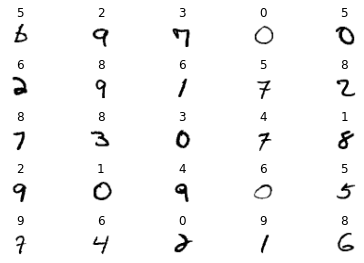

Data ready.


In [2]:
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## -------------------------
## Prepare data for training
## -------------------------

img_batch_size = 64

# prepare data for MNIST
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
mnist_training_set = torchvision.datasets.MNIST(root='./data/', train=True, 
                                          download=True, transform=transform)

# shuffle labels on training set
mnist_shuffled_labels = mnist_training_set.targets.numpy()
np.random.shuffle(mnist_shuffled_labels)
mnist_training_set.targets = torch.from_numpy(mnist_shuffled_labels)

mnist_training_loader = torch.utils.data.DataLoader(mnist_training_set, 
                                          batch_size=img_batch_size,
                                          shuffle=True)
# check that labels are shuffled
examples = iter(mnist_training_loader)
example_data, example_targets = examples.next()

fig = plt.figure()
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray_r')
  plt.title(f'{example_targets[i]}')
  plt.axis('off')
plt.show()

mnist_testing_set = torchvision.datasets.MNIST(root='./data/', train=False, 
                                          download=True, transform=transform)
mnist_testing_loader = torch.utils.data.DataLoader(mnist_testing_set, 
                                          batch_size=img_batch_size,
                                          shuffle=True)

print('Data ready.')

In [3]:
from common.MNIST_CNN_Models import ModerateCNN

## ---------------------------------------------------
## Train models [est. time: 36 hours for 5,000 epochs] 
## ---------------------------------------------------

epochs = 5000
model = ModerateCNN()
model.zero_grad()

training_loss = []
testing_loss = []
model_loss = []

for epoch in range(epochs):
    # train
    loss = model.train(mnist_training_loader)
    training_loss.append(loss)
    #test
    _, t_loss = model.test(mnist_testing_loader)
    testing_loss.append(t_loss)

    if epoch % 1000 == 999: # print updates every 1000 epochs
      print(f'Epoch: {epoch+1}/{epochs}\tTraining Loss: {loss:.6f}\t\tTesting Loss: {t_loss:.6f}', flush=True)

# save results
torch.save(model.state_dict(), 'results/3/models/shuffled_MNIST_model.pt')
np.savetxt('results/3/shuffled_MNIST_training_loss.txt', np.array(training_loss))
np.savetxt('results/3/shuffled_MNIST_testing_loss.txt', np.array(testing_loss))

Training model:
Epoch: 1000/5000	Training Loss: 1.939033		Testing Loss: 4.217010
Epoch: 2000/5000	Training Loss: 1.951500		Testing Loss: 4.563144
Epoch: 3000/5000	Training Loss: 1.963003		Testing Loss: 4.921676
Epoch: 4000/5000	Training Loss: 1.987989		Testing Loss: 5.110017
Epoch: 5000/5000	Training Loss: 2.023393		Testing Loss: 5.325513
Elapsed: 1586199862.2045696 min, 1613082726.740327 sec


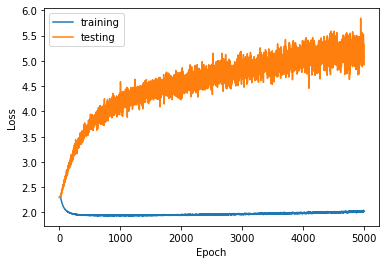

In [21]:
import matplotlib.pyplot as plt

## ------------
## Plot results
## ------------

# load results 
training_loss = np.loadtxt('results/3/shuffled_MNIST_training_loss.txt')
testing_loss = np.loadtxt('results/3/shuffled_MNIST_testing_loss.txt')

# plot training and testing loss over epochs
plt.plot(np.arange(0, epochs), training_loss, label='training')
plt.plot(np.arange(0, epochs), testing_loss, label='testing')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(f'results/3/fig_random_labels_loss.pdf')
plt.show()

### Part 2: Number of Parameters vs. Generalization

In [5]:
import torchvision
from torchvision import datasets, transforms

## -------------------------
## Prepare data for training
## -------------------------

img_batch_size = 32

# prepare data for MNIST
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
mnist_training_set = torchvision.datasets.MNIST(root='./data/', train=True, 
                                          download=True, transform=transform)
mnist_training_loader = torch.utils.data.DataLoader(mnist_training_set, 
                                          batch_size=img_batch_size,
                                          shuffle=True)

mnist_testing_set = torchvision.datasets.MNIST(root='./data/', train=False, 
                                          download=True, transform=transform)
mnist_testing_loader = torch.utils.data.DataLoader(mnist_testing_set, 
                                          batch_size=img_batch_size,
                                          shuffle=True)

print('Data ready.')

Data ready.


In [6]:
# model definitions
from common.MNIST_CNN_Models import ModerateCNN as CNN20K
from common.MNIST_CNN_Models import CNN10K, CNN50K, CNN100K, CNN200K
from common.MNIST_CNN_Models import CNN500K, CNN1M, CNN2M, CNN4M, CNN6M

## -----------------------------------------------
## Create models and validate number of parameters
## -----------------------------------------------

models = []
params = []

models.append(CNN10K())
models.append(CNN20K())
models.append(CNN50K())
models.append(CNN100K())
models.append(CNN200K())
models.append(CNN500K())
models.append(CNN1M())
models.append(CNN2M())
models.append(CNN4M())
models.append(CNN6M())

for i in range(len(models)):
  num_params = sum(p.numel() for p in models[i].parameters())
  params.append(num_params)
  print(f'[{i+1}] {models[i].__class__.__name__} parameters: {num_params}')

[1] CNN10K parameters: 10710
[2] ModerateCNN parameters: 21030
[3] CNN50K parameters: 50128
[4] CNN100K parameters: 100214
[5] CNN200K parameters: 198678
[6] CNN500K parameters: 558382
[7] CNN1M parameters: 1112174
[8] CNN2M parameters: 2224210
[9] CNN4M parameters: 4439250
[10] CNN6M parameters: 6313834


In [4]:
## ------------------------------------------------
## Train models [est. time: 6 hours with 10 epochs] 
## ------------------------------------------------

epochs = 10

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

# train each model
for i in range(len(models)):
    models[i].zero_grad()

    print(f'[{i+1}] Training {models[i].__class__.__name__} model:')

    for epoch in range(epochs):
        #train
        loss = models[i].train(mnist_training_loader)

        if epoch % (epochs/2) == (epochs/2)-1: # print updates twice
            print(f'Epoch: {epoch+1}/{epochs}\tTraining Loss: {loss:.6f}', flush=True)

    # test
    acc, _ = models[i].test(mnist_training_loader)
    t_acc, t_loss = models[i].test(mnist_testing_loader)

    training_loss.append(loss)
    training_acc.append(acc)
    testing_loss.append(t_loss)
    testing_acc.append(t_acc)

    torch.save(models[i].state_dict(), f'results/3/models/CNN_model{i}.pt')

# save results arranged [training_loss training_acc testing_loss testing_acc]
np.savetxt('results/3/parameters_results.txt', np.stack([training_loss, training_acc, testing_loss, testing_acc], axis=0))

[1] Training CNN10K model:
Epoch: 5/10	Training Loss: 0.037012
Epoch: 10/10	Training Loss: 0.021339
[2] Training ModerateCNN model:
Epoch: 5/10	Training Loss: 0.030230
Epoch: 10/10	Training Loss: 0.015187
[3] Training CNN50K model:
Epoch: 5/10	Training Loss: 0.023270
Epoch: 10/10	Training Loss: 0.009003
[4] Training CNN100K model:
Epoch: 5/10	Training Loss: 0.018139
Epoch: 10/10	Training Loss: 0.004862
[5] Training CNN200K model:
Epoch: 5/10	Training Loss: 0.016643
Epoch: 10/10	Training Loss: 0.003605
[6] Training CNN500K model:
Epoch: 5/10	Training Loss: 0.013603
Epoch: 10/10	Training Loss: 0.002653
[7] Training CNN1M model:
Epoch: 5/10	Training Loss: 0.012896
Epoch: 10/10	Training Loss: 0.001253
[8] Training CNN2M model:
Epoch: 5/10	Training Loss: 0.010927
Epoch: 10/10	Training Loss: 0.001662
[9] Training CNN4M model:
Epoch: 5/10	Training Loss: 0.010214
Epoch: 10/10	Training Loss: 0.001457
[10] Training CNN6M model:
Epoch: 5/10	Training Loss: 0.009123
Epoch: 10/10	Training Loss: 0.00

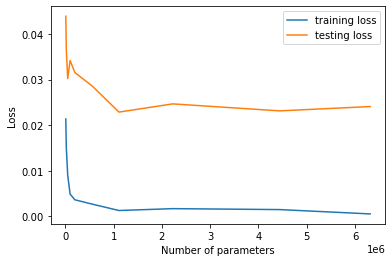

In [20]:
import matplotlib.pyplot as plt

## ------------
## Plot results
## ------------

# load results
param_results = np.loadtxt('results/3/parameters_results.txt')

# plot training and testing loss vs number of parameters
plt.plot(params, param_results[0,:], label='training loss')
plt.plot(params, param_results[2,:], label='testing loss')
plt.legend()
plt.xlabel('Number of parameters')
plt.ylabel('Loss')
plt.savefig(f'results/3/fig_parameters_loss.pdf')
plt.show()

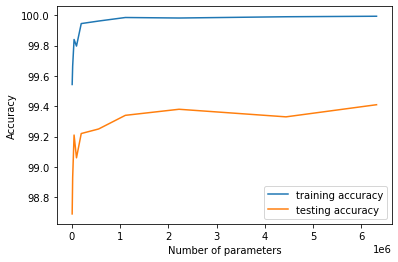

In [19]:
# plot training and testing accuracy vs number of parameters
plt.plot(params, param_results[1,:], label='training accuracy')
plt.plot(params, param_results[3,:], label='testing accuracy')
plt.legend()
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy')
plt.savefig(f'results/3/fig_parameters_acc.pdf')
plt.show()

### Part 3: Flatness vs. Generalization

#### Part 3a: Visualize the line between two trained models

In [13]:
import torchvision
from torchvision import datasets, transforms

## -------------------------
## Prepare data for training
## -------------------------

m1_batch_size = 64
m2_batch_size = 1024

# prepare data for MNIST
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
mnist_training_set = torchvision.datasets.MNIST(root='./data/', train=True, 
                                          download=True, transform=transform)
m1_training_loader = torch.utils.data.DataLoader(mnist_training_set, 
                                          batch_size=m1_batch_size,
                                          shuffle=True)
m2_training_loader = torch.utils.data.DataLoader(mnist_training_set, 
                                          batch_size=m2_batch_size,
                                          shuffle=True)

mnist_testing_set = torchvision.datasets.MNIST(root='./data/', train=False, 
                                          download=True, transform=transform)
mnist_testing_loader = torch.utils.data.DataLoader(mnist_testing_set, 
                                          batch_size=m2_batch_size,
                                          shuffle=True)

print('Data ready.')

Data ready.


In [4]:
from common.MNIST_CNN_Models import ModerateCNN

## -----------------------------------------------
## Train models [est. time: 15 min with 20 epochs] 
## -----------------------------------------------

epochs = 20

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

m1 = ModerateCNN()
m2 = ModerateCNN()
m1.zero_grad()
m2.zero_grad()

# train both models with different batch sizes
print('[1] Training m1:')
for epoch in range(epochs):
    loss = m1.train(m1_training_loader)
    if epoch % (epochs/2) == (epochs/2)-1: # print updates twice
        print(f'Epoch: {epoch+1}/{epochs}\tTraining Loss: {loss:.6f}', flush=True)

print('[2] Training m2:')
for epoch in range(epochs):
    loss = m2.train(m2_training_loader)
    if epoch % (epochs/2) == (epochs/2)-1: # print updates twice
        print(f'Epoch: {epoch+1}/{epochs}\tTraining Loss: {loss:.6f}', flush=True)

torch.save(m1.state_dict(), f'results/3/models/CNN_m1_batch=64.pt')
torch.save(m2.state_dict(), f'results/3/models/CNN_m2_batch=1024.pt')

[1] Training m1:
Epoch: 10/20	Training Loss: 0.016691
Epoch: 20/20	Training Loss: 0.004472
[2] Training m2:
Epoch: 10/20	Training Loss: 0.084125
Epoch: 20/20	Training Loss: 0.053720


In [5]:
## -------------------------------
## Test linear interpolation model 
## -------------------------------

results = []

# create model as linear interpolation of m1 & m2
m_alpha = ModerateCNN()
for alpha in np.arange(-1.0, 2.01, 0.01):
    # create linear interpolated parameters for new model
    for m1_p, m2_p, ma_p in zip(m1.parameters(), m2.parameters(), m_alpha.parameters()):
        ma_p.data = ((1 - alpha.round(3)) * m1_p.data) + (alpha.round(3) * m2_p.data)
    
    # log performance
    train_acc, train_loss = m_alpha.test(m1_training_loader)
    test_acc, test_loss = m_alpha.test(mnist_testing_loader)
    results.append([train_loss, test_loss, train_acc, test_acc])

# save results
np.savetxt('results/3/interpolated_model_results.txt', np.array(results))

Duration: 1:10:05.147672


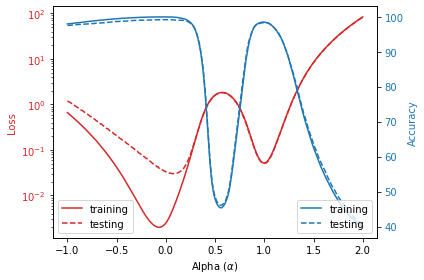

In [18]:
import matplotlib.pyplot as plt

## ------------
## Plot results
## ------------

# load results
interpol_results = np.loadtxt('results/3/interpolated_model_results.txt')

# hybrid model
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(np.arange(-1.0, 2.01, 0.01), interpol_results[:,0], '-', color=color, label='training')
ax1.plot(np.arange(-1.0, 2.01, 0.01), interpol_results[:,1], '--', color=color, label='testing')
ax1.set_ylabel('Loss', color=color)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend(loc='lower left')

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.plot(np.arange(-1.0, 2.01, 0.01), interpol_results[:,2], '-', color=color, label='training')
ax2.plot(np.arange(-1.0, 2.01, 0.01), interpol_results[:,3], '--', color=color, label='testing')
ax2.set_ylabel('Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.legend(loc='lower right')
ax1.set_xlabel(r'Alpha ($\alpha$)')
fig.tight_layout()
plt.savefig(f'results/3/fig_hybrid_model_interpolation.pdf')
plt.show()

#### Part 3b: Sensitivity

In [26]:
import torchvision
from torchvision import datasets, transforms

## -------------------------
## Prepare data for training
## -------------------------

batch_sizes = [16, 32, 64, 256, 1024]

# prepare data for MNIST
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
mnist_training_set = torchvision.datasets.MNIST(root='./data/', train=True, 
                                          download=True, transform=transform)

mnist_testing_set = torchvision.datasets.MNIST(root='./data/', train=False, 
                                          download=True, transform=transform)

training_loaders = []
for i in range(len(batch_sizes)):
    tmp_loader = torch.utils.data.DataLoader(mnist_training_set, 
                                          batch_size=batch_sizes[i],
                                          shuffle=True)
    training_loaders.append(tmp_loader)

mnist_testing_loader = torch.utils.data.DataLoader(mnist_testing_set, 
                                          batch_size=batch_sizes[4],
                                          shuffle=True)

print('Data ready.')

Data ready.


In [ ]:
## --------------------------------
## Train models [est. time: 17 hrs] 
## --------------------------------

epochs = 20

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []
sensitivity = []

# train each model with a different batch size
for i in range(len(batch_sizes)):
    model = ModerateCNN()
    model.zero_grad()

    print(f'[{i+1}] Training model with batch size {batch_sizes[i]}:')

    for epoch in range(epochs):
        #train
        loss = model.train(training_loaders[i])
        if epoch % (epochs/2) == (epochs/2)-1: # print updates twice
            print(f'Epoch: {epoch+1}/{epochs}\tTraining Loss: {loss:.6f}', flush=True)

    # test
    acc, _ = models[i].test(mnist_training_loader)
    t_acc, t_loss = models[i].test(mnist_testing_loader)
    training_loss.append(loss)
    training_acc.append(acc)
    testing_loss.append(t_loss)
    testing_acc.append(t_acc)

    # calculate sensitivity
    loss_grad = autograd.grad(inputs, loss_with_grad_fn, create_graph=True, allow_unused=True)
    s = np.linalg.norm(loss_grad, 'fro')
    sensitivity.append(s)

    torch.save(model.state_dict(), f'results/3/models/CNN_batch_size={batch_sizes[i]}.pt')

# save results
np.savetxt('results/3/sensitivity_results.txt', np.stack([batch_sizes, sensitivity, training_loss, 
                                                training_acc, testing_loss, testing_acc], axis=0))

In [ ]:
## ------------
## Plot results
## ------------

# load results 
results = np.loadtxt('results/3/sensitivity_results.txt')